# Outlier

✅ 총 프레임 수: 436


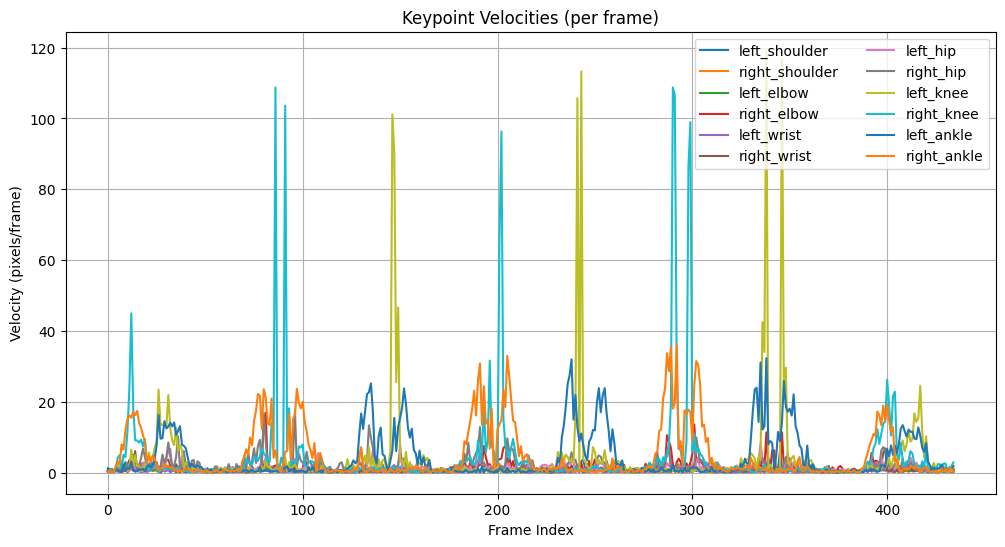

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from math import acos, degrees

# ---------------------- 경로 ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/17_누워서 번갈아 다리 들기_JSON"
)

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    """JSON에서 keypoints 좌표만 로드"""
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    """세 점 사이 각도 계산"""
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)+1e-6)
    return degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- 인덱스 정의 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

# ---------------------- 데이터 적재 ----------------------
all_keypoints = []
for json_file in sorted(KP_DIR.glob("*.json")):
    all_keypoints.append(load_keypoints(json_file))
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

print(f"✅ 총 프레임 수: {len(all_keypoints)}")

# ---------------------- Velocity 계산 ----------------------
velocities = {}  # {keypoint_name: [velocity per frame]}

for name, idx in keypoint_indices.items():
    # 프레임 간 이동 거리 = velocity
    diffs = np.linalg.norm(np.diff(all_keypoints[:, idx, :], axis=0), axis=1)
    velocities[name] = diffs  # (n_frames-1,) 크기

# ---------------------- 시각화 ----------------------
plt.figure(figsize=(12,6))

for name, vals in velocities.items():
    plt.plot(vals, label=name)

plt.title("Keypoint Velocities (per frame)")
plt.xlabel("Frame Index")
plt.ylabel("Velocity (pixels/frame)")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.show()


In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm  # 진행률 표시

# ---------------------- 경로 ----------------------
FRAME_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/1_FRAME_OLD/sample_data/ward_sample_video/17_누워서 번갈아 다리 들기_frames"
)

KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/17_누워서 번갈아 다리 들기_JSON"
)

OUT_PATH = "skeleton_overlay_corrected.mp4"

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

# ---------------------- 인덱스 정의 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

bone_pairs = [
    ("left_shoulder","left_elbow"),
    ("left_elbow","left_wrist"),
    ("right_shoulder","right_elbow"),
    ("right_elbow","right_wrist"),
    ("left_hip","left_knee"),
    ("left_knee","left_ankle"),
    ("right_hip","right_knee"),
    ("right_knee","right_ankle"),
    ("left_shoulder","left_hip"),
    ("right_shoulder","right_hip"),
    ("left_shoulder","right_shoulder"),
    ("left_hip","right_hip")
]

# ---------------------- 데이터 적재 ----------------------
all_keypoints = []
json_files = sorted(KP_DIR.glob("*.json"))
for json_file in tqdm(json_files, desc="Loading keypoints"):
    all_keypoints.append(load_keypoints(json_file))
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

print(f"✅ 총 프레임 수: {len(all_keypoints)}")

# ---------------------- Outlier 보정 ----------------------
def fix_outliers(all_keypoints, vel_thresh=40):
    """
    이전 프레임과 비교해서 threshold 이상 움직인 keypoint는
    outlier로 간주하고 이전 프레임 값으로 교체
    """
    corrected = all_keypoints.copy()

    for f in range(1, len(all_keypoints)):
        diffs = np.linalg.norm(corrected[f] - corrected[f-1], axis=1)
        for name, idx in keypoint_indices.items():
            if diffs[idx] > vel_thresh:
                corrected[f, idx] = corrected[f-1, idx]  # 이전 프레임 값으로 덮어쓰기

    return corrected

all_keypoints_corrected = fix_outliers(all_keypoints, vel_thresh=60)

# ---------------------- Skeleton Overlay Video ----------------------
def save_skeleton_overlay_video(frame_dir, all_keypoints, out_path="skeleton_overlay_corrected.mp4", fps=30):
    frame_files = sorted(frame_dir.glob("*.jpg"))  # jpg 프레임 가정
    if not frame_files:
        frame_files = sorted(frame_dir.glob("*.png"))  # png fallback

    # 첫 프레임 크기 확인
    sample_frame = cv2.imread(str(frame_files[0]))
    h, w, _ = sample_frame.shape
    size = (w, h)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, fps, size)

    for f, frame_file in enumerate(tqdm(frame_files, desc="Generating video")):
        frame_img = cv2.imread(str(frame_file))
        points = all_keypoints[f].astype(int)

        # skeleton 그리기
        for (a,b) in bone_pairs:
            ia, ib = keypoint_indices[a], keypoint_indices[b]
            cv2.line(frame_img,
                     (points[ia,0], points[ia,1]),
                     (points[ib,0], points[ib,1]),
                     (0,255,0), 2)

        # keypoints 그리기
        for (name, idx) in keypoint_indices.items():
            x,y = points[idx]
            cv2.circle(frame_img, (x,y), 4, (0,0,255), -1)

        writer.write(frame_img)

    writer.release()
    print(f"✅ 보정된 Skeleton overlay 영상 저장 완료: {out_path}")

# ---------------------- 실행 ----------------------
save_skeleton_overlay_video(FRAME_DIR, all_keypoints_corrected, out_path=OUT_PATH, fps=30)


Loading keypoints: 100% 436/436 [00:00<00:00, 8220.24it/s]


✅ 총 프레임 수: 436


Generating video: 100% 436/436 [00:07<00:00, 58.62it/s]

✅ 보정된 Skeleton overlay 영상 저장 완료: skeleton_overlay_corrected.mp4


# ICP Outlier Detection

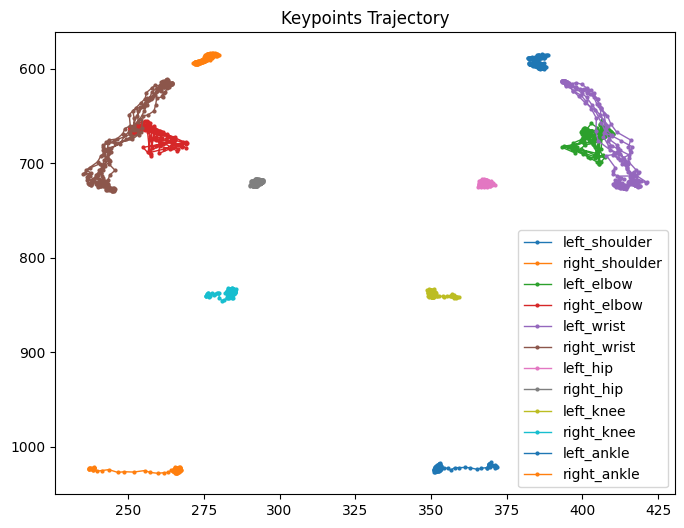

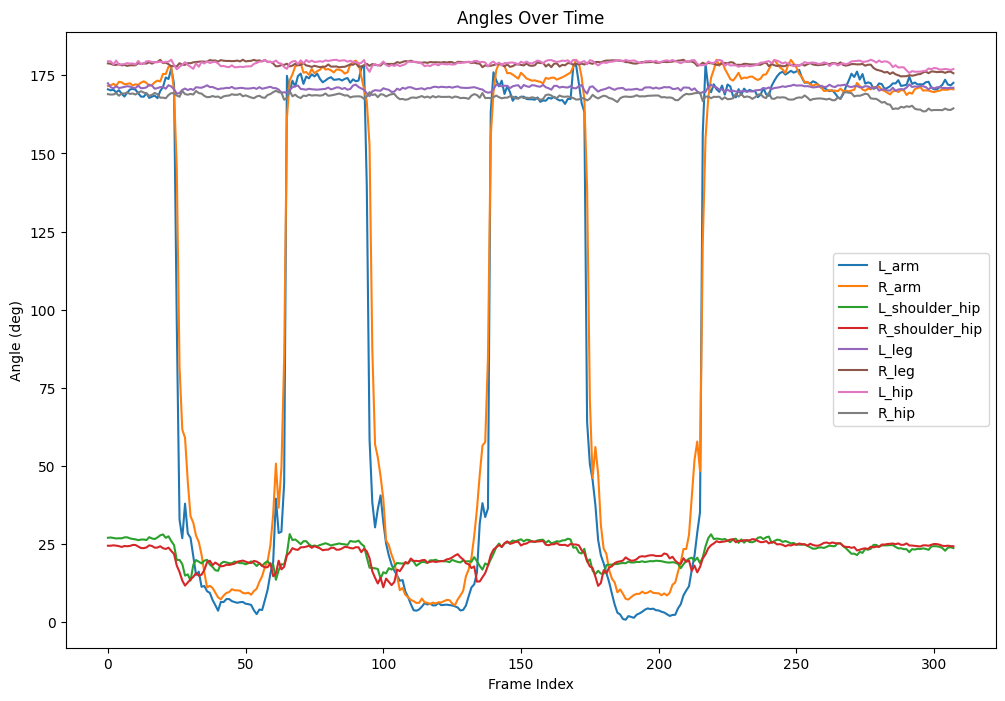

In [3]:
#!/usr/bin/env python  # 파이썬 실행기 지정
# -*- coding: utf-8 -*-  # UTF-8 인코딩 사용

# ---------------------- 라이브러리 임포트 ----------------------
import json  # JSON 파일 읽기
from pathlib import Path  # 경로 관리
import numpy as np  # 수치 계산용
import matplotlib.pyplot as plt  # 그래프 시각화용
from math import acos, degrees  # 코사인 법칙으로 각도 계산
from sklearn.neighbors import NearestNeighbors  # ICP 매칭용

# ---------------------- 경로 ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_JSON"
)  # JSON 키포인트가 저장된 폴더 경로

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    """JSON에서 keypoints 좌표만 로드"""
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # 첫 번째 사람의 keypoints (17개, 2D 좌표)

def angle_between(p1, p2, p3):
    """세 점 p1-p2-p3 사이의 각도(도 단위)"""
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- 인덱스 정의 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

# 8개 관절각 정의
angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- 데이터 적재 ----------------------
all_keypoints, all_angles = [], {k: [] for k in angles_def.keys()}

for json_file in sorted(KP_DIR.glob("*.json")):
    kp = load_keypoints(json_file)  # keypoints 로드 (17,2)
    all_keypoints.append(kp)
    for name, (i, j, k) in angles_def.items():
        all_angles[name].append(angle_between(kp[i], kp[j], kp[k]))

all_keypoints = np.array(all_keypoints)  # (frame, 17, 2)
for k in all_angles:
    all_angles[k] = np.array(all_angles[k])

# ---------------------- ICP 함수 ----------------------
def icp(source, target, max_iter=20):
    """
    source: (N,2), target: (N,2)
    Rigid transform ICP (translation + rotation)
    """
    src = source.copy()
    tgt = target.copy()

    for _ in range(max_iter):
        # 최근접 점 매칭
        nbrs = NearestNeighbors(n_neighbors=1).fit(tgt)
        distances, indices = nbrs.kneighbors(src)
        matched_tgt = tgt[indices[:,0]]

        # 평균 제거
        mu_src, mu_tgt = np.mean(src, axis=0), np.mean(matched_tgt, axis=0)
        src_c, tgt_c = src - mu_src, matched_tgt - mu_tgt

        # SVD로 회전 추정
        H = src_c.T @ tgt_c
        U, _, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1,:] *= -1
            R = Vt.T @ U.T
        t = mu_tgt - R @ mu_src

        # 변환 적용
        src = (R @ src.T).T + t

    return src, distances[:,0]

# ---------------------- 시각화 ----------------------
# 1. Keypoints 궤적
plt.figure(figsize=(8,6))
for name, idx in keypoint_indices.items():
    xs, ys = all_keypoints[:,idx,0], all_keypoints[:,idx,1]
    plt.plot(xs, ys, marker="o", markersize=2, linewidth=1, label=name)
plt.gca().invert_yaxis()
plt.legend()
plt.title("Keypoints Trajectory")
plt.show()

# 2. 각도 시계열
plt.figure(figsize=(12,8))
for name, vals in all_angles.items():
    plt.plot(vals, label=name)
plt.legend()
plt.title("Angles Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Angle (deg)")
plt.show()


## 주요 keypoints 선택 코드

In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# 📌 목적: 모든 keypoints/angles을 계산하되,
#         trajectory 기반으로 "중요한 keypoints/angles"를 자동 선택하는 코드

import json
from pathlib import Path
import numpy as np
from math import acos, degrees

# ---------------------- 경로 ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_JSON"
)

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    """JSON에서 keypoints 좌표만 로드"""
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    """세 점 p1-p2-p3 사이의 각도(도 단위)"""
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- 인덱스 정의 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- 데이터 적재 ----------------------
all_keypoints, all_angles = [], {k: [] for k in angles_def.keys()}

for json_file in sorted(KP_DIR.glob("*.json")):
    kp = load_keypoints(json_file)
    all_keypoints.append(kp)
    for name, (i, j, k) in angles_def.items():
        all_angles[name].append(angle_between(kp[i], kp[j], kp[k]))

all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)
for k in all_angles:
    all_angles[k] = np.array(all_angles[k])

# ---------------------- 중요도 스코어 ----------------------
# 각 keypoint trajectory 길이와 분산 계산
trajectory_scores = {}
for name, idx in keypoint_indices.items():
    coords = all_keypoints[:, idx, :]
    diffs = np.diff(coords, axis=0)
    dist = np.sum(np.linalg.norm(diffs, axis=1))  # 전체 이동거리
    var = np.var(coords, axis=0).sum()  # 분산
    trajectory_scores[name] = dist + var  # 단순 합으로 중요도 정의

# 중요도가 높은 keypoints 상위 K개 선택
K = 2
selected_keypoints = sorted(trajectory_scores, key=trajectory_scores.get, reverse=True)[:K]

# ---------------------- 선택된 angles ----------------------
# 선택된 keypoints가 포함된 angles만 남김
selected_angles = []
for angle_name, (i, j, k) in angles_def.items():
    inv_map = {v: k for k, v in keypoint_indices.items()}
    if inv_map[i] in selected_keypoints or inv_map[j] in selected_keypoints or inv_map[k] in selected_keypoints:
        selected_angles.append(angle_name)

# ---------------------- 결과 출력 ----------------------
print("📌 Keypoints 중요도 순위:")
for k, v in sorted(trajectory_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{k:15s} {v:.2f}")

print("\n✅ 선택된 분석용 keypoints:", selected_keypoints)
print("✅ 선택된 분석용 angles:", selected_angles)


📌 Keypoints 중요도 순위:
left_wrist      2999.60
right_wrist     2887.80
left_elbow      795.72
right_elbow     692.08
left_ankle      403.77
right_knee      369.91
right_ankle     335.40
left_shoulder   326.27
right_shoulder  316.61
left_knee       302.12
left_hip        274.53
right_hip       242.20

✅ 선택된 분석용 keypoints: ['left_wrist', 'right_wrist']
✅ 선택된 분석용 angles: ['L_arm', 'R_arm']


# Peak 탐지 법
Peak 지점을 찾아서 가장 낮았다가 높아졌다 하는 곳을 찾아 그것을 이용해 counting 하는 방법

In [5]:
import numpy as np
from scipy.signal import find_peaks

def count_reps_peaks(angle_series, prominence=10, distance=10):
    """
    angle_series : numpy array (각도 시계열)
    prominence   : 피크의 최소 높이차 (작을수록 더 많은 피크 탐지)
    distance     : 인접 피크 간 최소 거리 (프레임 단위)
    """
    peaks, _ = find_peaks(angle_series, prominence=prominence, distance=distance)
    return len(peaks), peaks


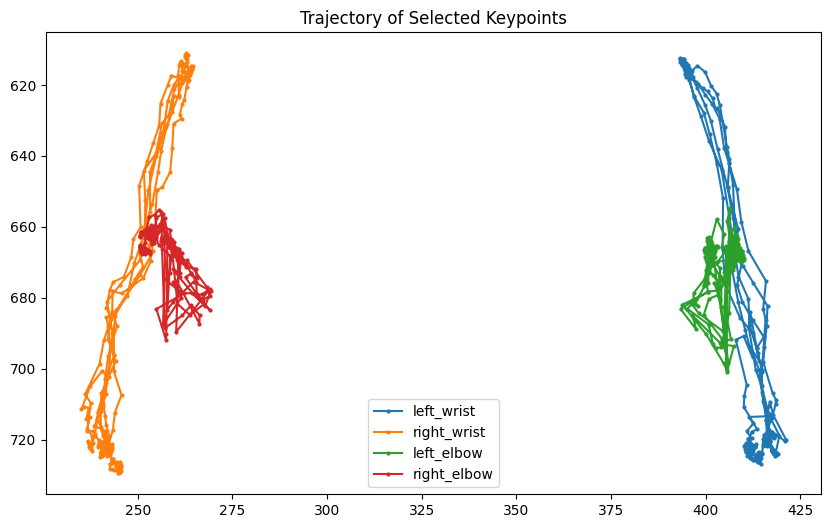

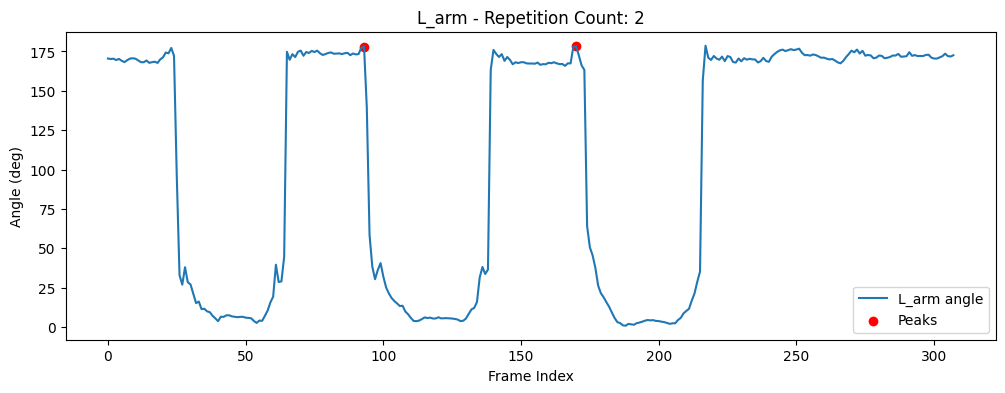

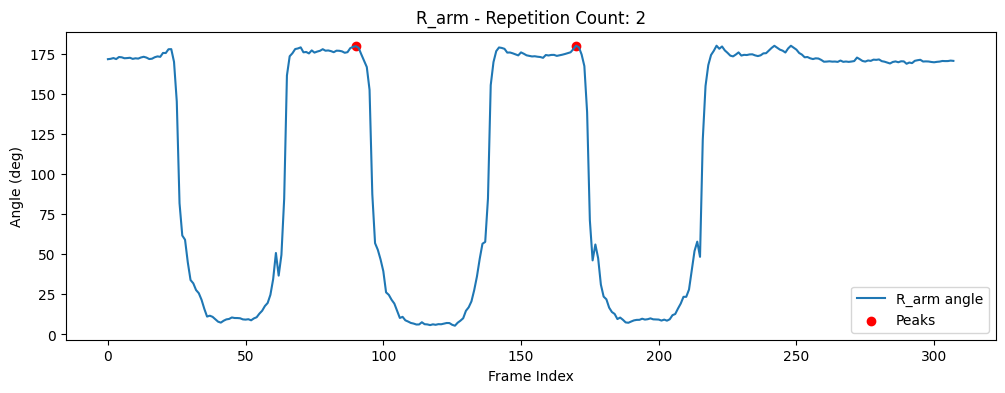

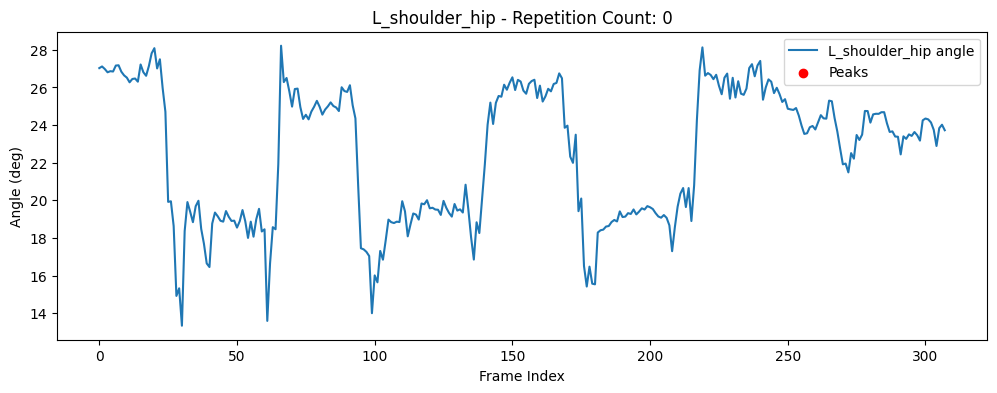

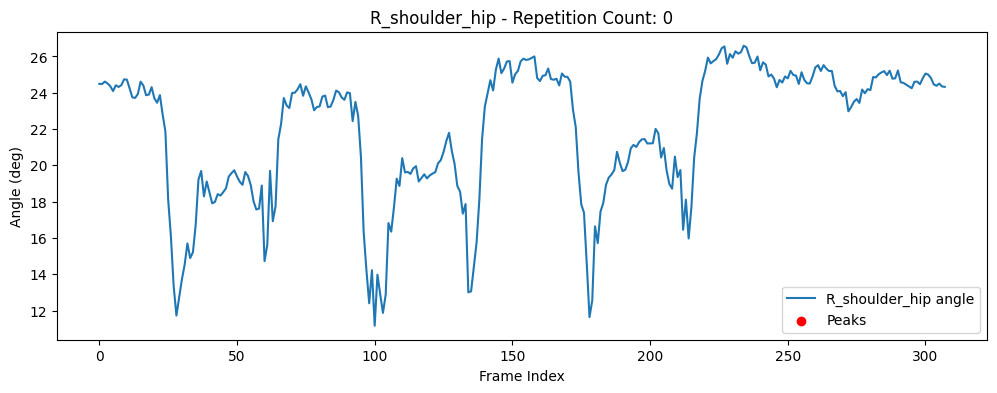

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ---------------------- 선택된 keypoints & angles ----------------------
selected_keypoints = ['left_wrist', 'right_wrist', 'left_elbow', 'right_elbow']
selected_angles = ['L_arm', 'R_arm', 'L_shoulder_hip', 'R_shoulder_hip']

# ---------------------- Keypoint Trajectory 시각화 ----------------------
plt.figure(figsize=(10,6))
for name in selected_keypoints:
    idx = keypoint_indices[name]
    xs, ys = all_keypoints[:, idx, 0], all_keypoints[:, idx, 1]
    plt.plot(xs, ys, marker="o", markersize=2, label=name)
plt.gca().invert_yaxis()
plt.title("Trajectory of Selected Keypoints")
plt.legend()
plt.show()

# ---------------------- Angles Time-Series & Peak Detection ----------------------
for ang_name in selected_angles:
    series = all_angles[ang_name]

    # Peak detection
    peaks, _ = find_peaks(series, prominence=15, distance=10)

    plt.figure(figsize=(12,4))
    plt.plot(series, label=f"{ang_name} angle")
    plt.scatter(peaks, series[peaks], color="red", label="Peaks")
    plt.title(f"{ang_name} - Repetition Count: {len(peaks)}")
    plt.xlabel("Frame Index")
    plt.ylabel("Angle (deg)")
    plt.legend()
    plt.show()


# FFT

## FFT

In [28]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
import numpy as np
import pandas as pd
from pathlib import Path
from math import acos, degrees

# ---------------------- 경로 ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_JSON"
)

OUT_CSV = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/angle_trajectory.csv"
)

fps = 30

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)+1e-6)
    return degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- 인덱스 정의 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
}

angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
}

# ---------------------- 데이터 적재 ----------------------
json_files = sorted(KP_DIR.glob("*.json"))
all_keypoints = [load_keypoints(f) for f in json_files]
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

# ---------------------- 각도 시계열 생성 ----------------------
all_angles = {name: [] for name in angles_def}
for frame in all_keypoints:
    for name, (i,j,k) in angles_def.items():
        all_angles[name].append(angle_between(frame[i], frame[j], frame[k]))

# DataFrame 변환
df = pd.DataFrame({
    "frame": np.arange(len(all_keypoints)),
    "L_arm": all_angles["L_arm"],
    "R_arm": all_angles["R_arm"],
})

# ---------------------- CSV 저장 ----------------------
df.to_csv(OUT_CSV, index=False)
print(f"✅ Angle trajectory CSV 저장 완료: {OUT_CSV}")


✅ Angle trajectory CSV 저장 완료: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/angle_trajectory.csv


In [31]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# 라이브러리 임포트
import numpy as np  # 수치 계산을 위해 넘파이를 임포트해요.
import pandas as pd  # CSV 파일 로드를 위해 판다스를 임포트해요.
import cv2  # 영상 입출력과 오버레이를 위해 OpenCV를 임포트해요.
from pathlib import Path  # 경로 처리를 위해 Path를 임포트해요.
from tqdm import tqdm  # 진행률 표시를 위해 tqdm을 임포트해요.

# SciPy가 있으면 find_peaks를 쓰고 없으면 간단 대체 로직을 써요.
try:
    from scipy.signal import find_peaks  # 신뢰도 높은 피크 탐지를 위해 SciPy의 find_peaks를 임포트해요.
    SCIPY_OK = True  # SciPy 사용 가능 여부를 True로 기록해요.
except Exception:
    SCIPY_OK = False  # SciPy가 없으면 False로 기록해요.

# ---------------------- 경로 설정 ----------------------
FRAME_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/1_FRAME_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_frames"
)  # 프레임 이미지들이 저장된 디렉터리 경로를 지정해요.

CSV_PATH = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/angle_trajectory.csv"
)  # angle_trajectory.csv 파일 경로를 지정해요.

OUT_PATH = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/angle_count_overlay.mp4"
)  # 결과 MP4 파일 저장 경로를 지정해요.

FPS = 30  # 영상 프레임레이트를 30fps로 설정해요.

# ---------------------- 유틸: 간단 이동평균 스무딩 ----------------------
def moving_average(x: np.ndarray, win_frames: int) -> np.ndarray:
    win = max(3, int(win_frames) | 1)  # 홀수 윈도우를 보장하기 위해 비트 OR로 1을 강제해요.
    pad = win // 2  # 가장자리 처리를 위한 패딩 길이를 계산해요.
    left, right = x[0], x[-1]  # 양 끝점을 복제하여 패딩에 사용해요.
    padded = np.concatenate([np.full(pad, left), x, np.full(pad, right)])  # 양끝 패딩을 덧붙여 경계 왜곡을 줄여요.
    kernel = np.ones(win) / win  # 균일 가중치의 이동평균 커널을 생성해요.
    smoothed = np.convolve(padded, kernel, mode="valid")  # 컨볼루션으로 스무딩 값을 계산해요.
    return smoothed  # 스무딩된 시계열을 반환해요.

# ---------------------- 유틸: SciPy 대체 피크 탐지기 ----------------------
def simple_find_peaks(x: np.ndarray, distance: int = 1) -> np.ndarray:
    idx = np.where((x[1:-1] > x[:-2]) & (x[1:-1] > x[2:]))[0] + 1  # 이웃보다 큰 내부 최대값의 인덱스를 찾어요.
    picked = []  # 최소 간격 조건으로 걸러낼 인덱스 리스트를 만들어요.
    last = -10**9  # 마지막 채택 인덱스를 매우 작은 값으로 초기화해요.
    for i in idx:  # 모든 후보 인덱스를 순회해요.
        if i - last >= distance:  # 최소 간격을 만족하는 경우에만 채택해요.
            picked.append(i)  # 선택 인덱스를 결과에 추가해요.
            last = i  # 마지막 선택 인덱스를 갱신해요.
    return np.array(picked, dtype=int)  # 넘파이 배열로 반환해요.

# ---------------------- 1) CSV→누적 카운트 계산 ----------------------
def cum_count_from_csv(csv_path: Path, fps: int = 30,
                       prefer_valley: bool = True,
                       min_cycle_sec: float = 1.5,
                       smooth_window_sec: float = 0.5) -> np.ndarray:
    df = pd.read_csv(csv_path)  # CSV를 읽어 데이터프레임으로 로드해요.
    assert {"L_arm", "R_arm"}.issubset(df.columns), "CSV에 L_arm, R_arm 컬럼이 필요합니다."  # 필수 컬럼이 있는지 확인해요.
    signal_raw = (df["L_arm"].to_numpy() + df["R_arm"].to_numpy()) / 2.0  # 좌우 팔 각도를 평균하여 대표 신호를 만들어요.
    smoothed = moving_average(signal_raw, win_frames=int(round(smooth_window_sec * fps)))  # 이동평균으로 신호를 스무딩해요.
    min_distance = int(min_cycle_sec * fps)  # 동작 최소 주기로부터 최소 간격 프레임 수를 계산해요.
    if SCIPY_OK:  # SciPy 사용 가능 시 고급 피크 탐지를 사용해요.
        from scipy.signal import find_peaks  # 지역 범위에서 안전하게 재임포트해요.
        prom = float(np.percentile(np.abs(smoothed - np.median(smoothed)), 60))  # 신호 규모 기반 prominence 임계값을 계산해요.
        peaks, _ = find_peaks(smoothed, distance=min_distance, prominence=prom)  # 피크를 탐지해요.
        valleys, _ = find_peaks(-smoothed, distance=min_distance, prominence=prom)  # 밸리를 탐지해요.
    else:  # SciPy가 없으면 단순 피크 탐지기를 사용해요.
        peaks = simple_find_peaks(smoothed, distance=min_distance)  # 간단 피크 탐지 결과를 얻어요.
        valleys = simple_find_peaks(-smoothed, distance=min_distance)  # 간단 밸리 탐지 결과를 얻어요.
    chosen = valleys if prefer_valley else peaks  # 동작 정의에 맞춰 밸리 또는 피크를 기준으로 선택해요.
    cum = np.zeros(len(smoothed), dtype=float)  # 프레임별 누적 카운트를 저장할 배열을 만들어요.
    c = 0  # 누적 카운트를 0으로 시작해요.
    chosen_set = set(chosen.tolist())  # 포함 검사 속도를 높이기 위해 집합으로 변환해요.
    for i in range(len(smoothed)):  # 전체 프레임을 순회하며 누적 카운트를 계산해요.
        if i in chosen_set:  # 현재 프레임이 이벤트 프레임이면 누적 카운트를 증가해요.
            c += 1  # 이벤트를 만나면 카운트를 1 더해요.
        cum[i] = c  # 현재 프레임의 누적 카운트를 기록해요.
    return cum  # 프레임별 누적 카운트 배열을 반환해요.

# ---------------------- 2) 프레임→MP4 오버레이 저장 ----------------------
def save_count_overlay_video(frame_dir: Path, counts: np.ndarray,
                             out_path: Path, fps: int = 30) -> None:
    frame_files = sorted(frame_dir.glob("*.jpg")) + sorted(frame_dir.glob("*.jpeg")) + sorted(frame_dir.glob("*.png"))  # 지원 확장자 파일을 모두 수집해요.
    if not frame_files:  # 프레임이 하나도 없으면 에러를 발생시켜요.
        raise FileNotFoundError(f"No frame images found in: {frame_dir}")  # 프레임 경로 문제를 명시적으로 알려줘요.
    sample = cv2.imread(str(frame_files[0]))  # 첫 프레임을 읽어 영상 크기를 확인해요.
    h, w = sample.shape[:2]  # 영상 높이와 너비를 추출해요.
    vw = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))  # MP4 라이터를 생성해요.
    for f, img_path in enumerate(tqdm(frame_files, desc="Rendering MP4")):  # 전체 프레임을 순회하며 렌더링해요.
        img = cv2.imread(str(img_path))  # 프레임 이미지를 읽어요.
        idx = min(f, len(counts) - 1)  # 카운트 인덱스를 프레임 범위에 맞게 클램프해요.
        txt = f"Reps: {int(round(counts[idx]))}"  # 현재 프레임의 누적 카운트를 텍스트로 만들어요.
        cv2.putText(img, txt, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 4, cv2.LINE_AA)  # 영상 좌상단에 카운트를 오버레이해요.
        vw.write(img)  # 오버레이된 프레임을 영상으로 기록해요.
    vw.release()  # 비디오 라이터를 정상 종료해요.
    print(f"✅ Saved: {out_path}")  # 저장 완료 메시지를 출력해요.

# ---------------------- 실행부 ----------------------
if __name__ == "__main__":  # 스크립트 진입점을 정의해요.
    assert CSV_PATH.is_file(), f"CSV not found: {CSV_PATH}"  # CSV 경로가 유효한지 먼저 확인해요.
    assert FRAME_DIR.is_dir(), f"FRAME_DIR not found: {FRAME_DIR}"  # 프레임 디렉터리가 존재하는지 확인해요.
    counts = cum_count_from_csv(CSV_PATH, fps=FPS, prefer_valley=True, min_cycle_sec=1.5, smooth_window_sec=0.5)  # CSV로부터 누적 카운트를 계산해요.
    save_count_overlay_video(FRAME_DIR, counts, OUT_PATH, fps=FPS)  # 누적 카운트를 프레임에 오버레이하여 MP4로 저장해요.


Rendering MP4: 100% 308/308 [00:05<00:00, 58.42it/s]

✅ Saved: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/angle_count_overlay.mp4


## sliding FFT

✅ Keypoint left_wrist: 최종 repetition count ≈ 4


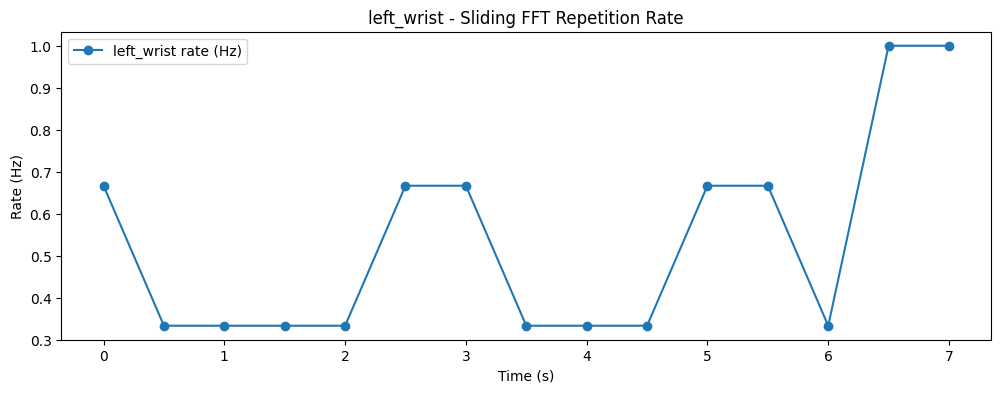

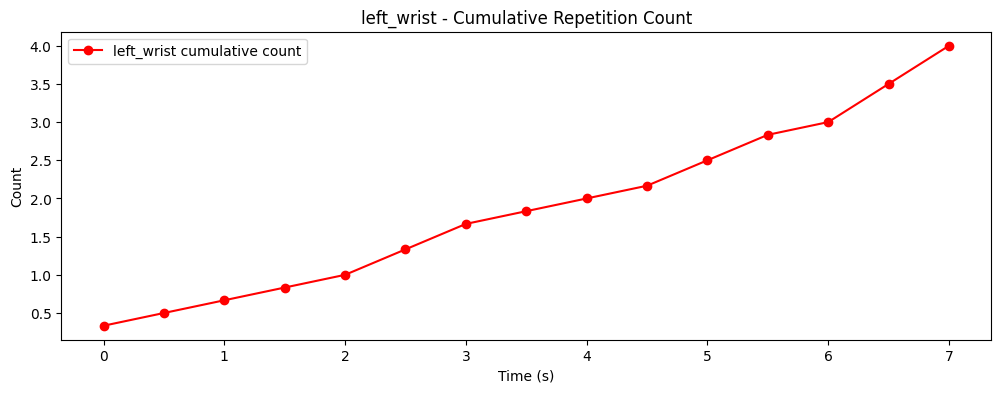

✅ Keypoint right_wrist: 최종 repetition count ≈ 4


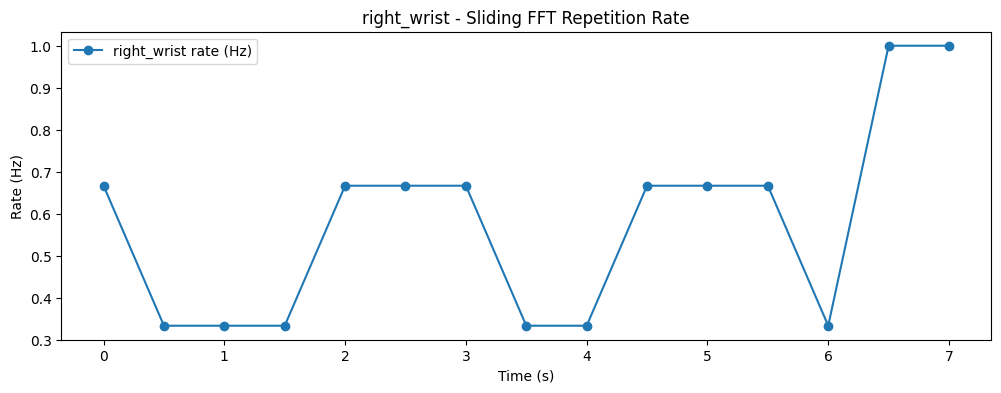

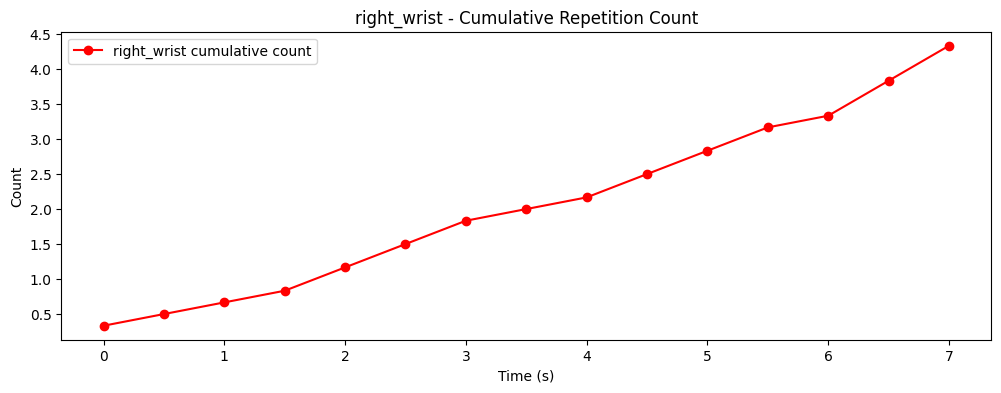

✅ Angle L_arm: 최종 repetition count ≈ 4


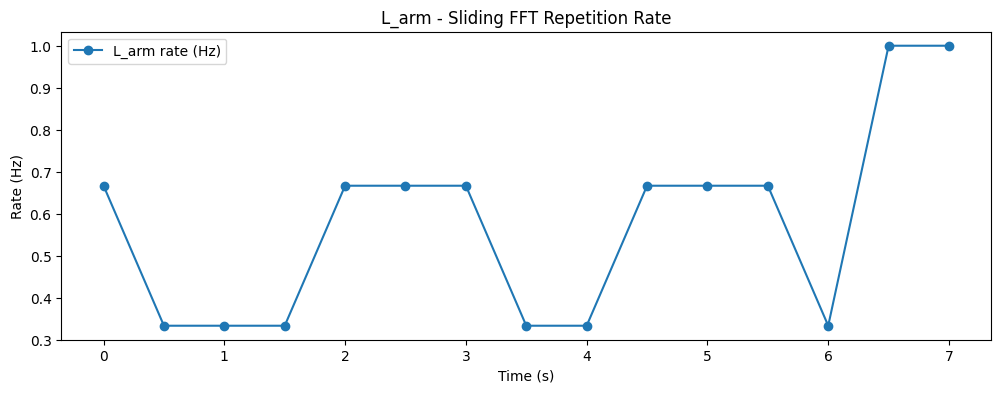

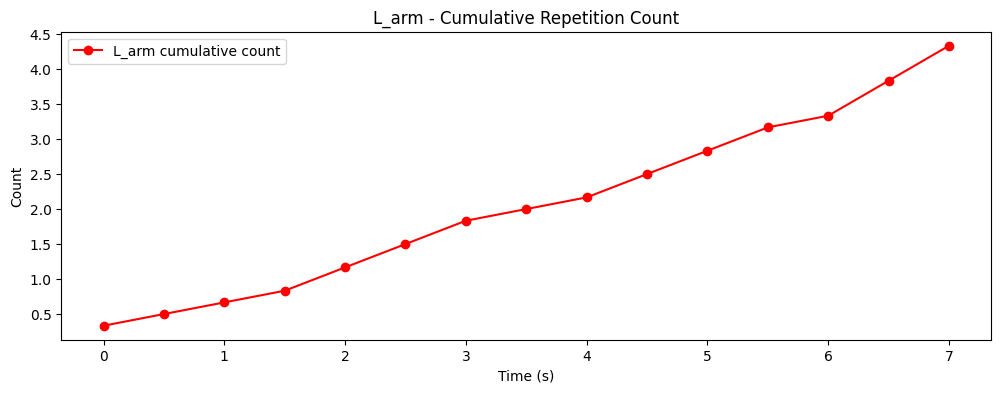

✅ Angle R_arm: 최종 repetition count ≈ 4


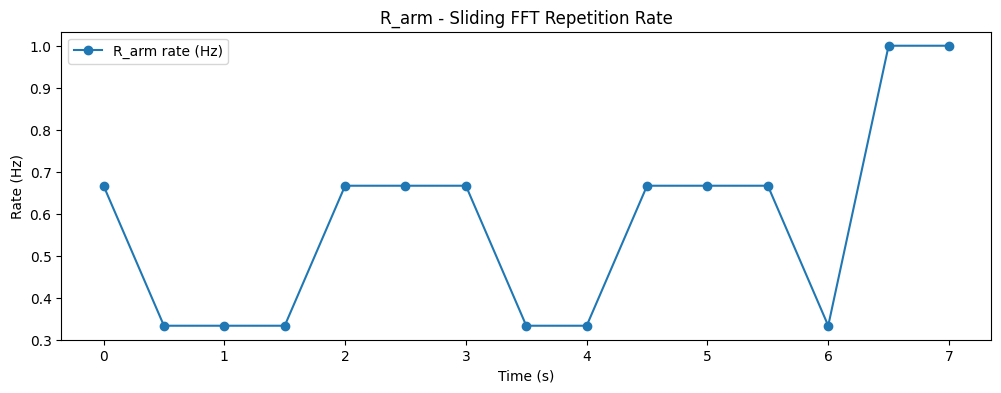

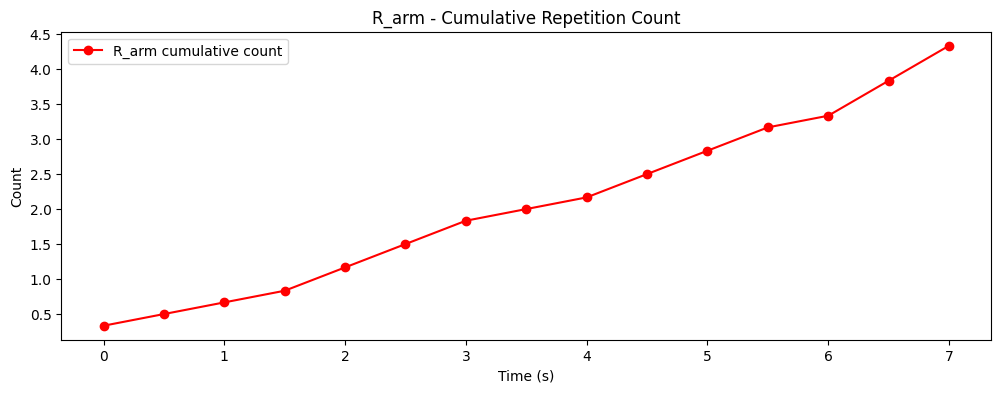

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- FFT 함수 ----------------------
def count_reps_fft(signal, fps=30):
    n = len(signal)
    yf = np.fft.rfft(signal - np.mean(signal))
    xf = np.fft.rfftfreq(n, 1/fps)
    yf_abs = np.abs(yf)
    freq = xf[1:][np.argmax(yf_abs[1:])]
    duration = n / fps
    reps = freq * duration
    return reps, freq

# ---------------------- Sliding Window FFT + 누적 Count ----------------------
def sliding_fft_count(signal, fps=30, window_sec=2, step_sec=0.5):
    W = int(window_sec * fps)   # 윈도우 크기 (프레임)
    S = int(step_sec * fps)     # 스텝 크기 (프레임)

    n = len(signal)
    rep_estimates = []
    times = []
    cum_count = []

    total_count = 0.0

    for start in range(0, n - W, S):
        window = signal[start:start+W]
        reps, freq = count_reps_fft(window, fps)

        # step_sec 동안 몇 번 반복했는지 ≈ rate × step_sec
        total_count += freq * step_sec
        rep_estimates.append(freq)
        times.append(start / fps)
        cum_count.append(total_count)

    return np.array(times), np.array(rep_estimates), np.array(cum_count)

# ---------------------- Keypoints (Magnitude) ----------------------
fps = 30
for name in selected_keypoints:
    idx = keypoint_indices[name]
    coords = all_keypoints[:, idx, :]
    mag_series = np.linalg.norm(coords - np.mean(coords, axis=0), axis=1)

    times, rep_rate, cum_count = sliding_fft_count(
        mag_series, fps=fps, window_sec=3, step_sec=0.5
    )

    print(f"✅ Keypoint {name}: 최종 repetition count ≈ {int(round(cum_count[-1]))}")

    # Repetition Rate 시각화
    plt.figure(figsize=(12,4))
    plt.plot(times, rep_rate, marker="o", label=f"{name} rate (Hz)")
    plt.title(f"{name} - Sliding FFT Repetition Rate")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.legend(); plt.show()

    # 누적 Count 시각화
    plt.figure(figsize=(12,4))
    plt.plot(times, cum_count, marker="o", color="red", label=f"{name} cumulative count")
    plt.title(f"{name} - Cumulative Repetition Count")
    plt.xlabel("Time (s)")
    plt.ylabel("Count")
    plt.legend(); plt.show()

# ---------------------- Angles ----------------------
for ang in selected_angles:
    series = all_angles[ang]

    times, rep_rate, cum_count = sliding_fft_count(
        mag_series, fps=fps, window_sec=3, step_sec=0.5
    )

    print(f"✅ Angle {ang}: 최종 repetition count ≈ {int(round(cum_count[-1]))}")

    # Repetition Rate 시각화
    plt.figure(figsize=(12,4))
    plt.plot(times, rep_rate, marker="o", label=f"{ang} rate (Hz)")
    plt.title(f"{ang} - Sliding FFT Repetition Rate")
    plt.xlabel("Time (s)")
    plt.ylabel("Rate (Hz)")
    plt.legend(); plt.show()

    # 누적 Count 시각화
    plt.figure(figsize=(12,4))
    plt.plot(times, cum_count, marker="o", color="red", label=f"{ang} cumulative count")
    plt.title(f"{ang} - Cumulative Repetition Count")
    plt.xlabel("Time (s)")
    plt.ylabel("Count")
    plt.legend(); plt.show()


In [25]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from math import acos, degrees

# ---------------------- 경로 ----------------------
FRAME_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/1_FRAME_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_frames"
)

KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_JSON"
)

OUT_PATH = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "ipynb/fft_count_overlay.mp4"
)

fps = 30

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"])  # (17,2)

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2)+1e-6)
    return degrees(np.arccos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- 인덱스 정의 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16
}

bone_pairs = [
    ("left_shoulder","left_elbow"), ("left_elbow","left_wrist"),
    ("right_shoulder","right_elbow"), ("right_elbow","right_wrist"),
    ("left_hip","left_knee"), ("left_knee","left_ankle"),
    ("right_hip","right_knee"), ("right_knee","right_ankle"),
    ("left_shoulder","left_hip"), ("right_shoulder","right_hip"),
    ("left_shoulder","right_shoulder"), ("left_hip","right_hip")
]

# ---------------------- 데이터 적재 ----------------------
json_files = sorted(KP_DIR.glob("*.json"))
all_keypoints = [load_keypoints(f) for f in json_files]
all_keypoints = np.array(all_keypoints)  # (frames, 17, 2)

print(f"✅ 총 프레임 수: {len(all_keypoints)}")


def count_reps_fft(signal, fps=30):
    n = len(signal)                             # 신호 길이 (프레임 개수)
    yf = np.fft.rfft(signal - np.mean(signal))  # FFT (평균을 빼서 DC 성분 제거)
    xf = np.fft.rfftfreq(n, 1/fps)              # 주파수 축 생성 (0 ~ Nyquist 주파수)
    yf_abs = np.abs(yf)                         # FFT 크기 스펙트럼 (진폭)
    freq = xf[1:][np.argmax(yf_abs[1:])]        # 0Hz 제외 후, 최대 peak의 주파수 선택
    duration = n / fps                          # 전체 신호 길이(초)
    reps = freq * duration                      # 반복 횟수 = 주파수(Hz) × 시간(초)
    return reps, freq                           # 반복 횟수, dominant frequency 리턴

# ---------------------- FFT 기반 Sliding Count ----------------------
def sliding_fft_count(signal, fps=30, window_sec=3.5, step_sec=0.5):
    W = int(window_sec * fps)                   # 윈도우 크기 (초 → 프레임 단위 변환)
    S = int(step_sec * fps)                     # 스텝 크기 (초 → 프레임 단위 변환)
    n = len(signal)                             # 전체 프레임 수
    cum_count = np.zeros(n)                     # 프레임별 누적 count 저장용 배열
    total_count = 0.0                           # 누적 카운트 초기화

    for start in range(0, n - W, S):                # 시작 프레임부터 끝까지 S 간격으로 윈도우 이동
        window = signal[start:start+W]              # 현재 구간의 신호 추출
        reps, freq = count_reps_fft(window, fps)    # 현재 윈도우에서 반복 횟수와 주파수 계산
        step_count = freq * step_sec                # 이번 step에서 증가할 count = freq × step 길이(초)
        total_count += step_count                   # 누적 카운트 갱신
        cum_count[start:start+S] = total_count      # 해당 step 구간에 누적 count 기록

    if np.any(cum_count == 0):                      # 아직 값이 없는 프레임은 마지막 total_count로 채움
        cum_count[cum_count == 0] = total_count

    return cum_count                                # 프레임별 누적 repetition count 반환


# ---------------------- 분석용 keypoint 선택 (예: left_wrist) ----------------------
idx = keypoint_indices["left_wrist"]
coords = all_keypoints[:, idx, :]
mag_series = np.linalg.norm(coords - np.mean(coords, axis=0), axis=1)

counts = sliding_fft_count(mag_series, fps=fps, window_sec=3, step_sec=0.5)
print(f"✅ 최종 repetition count ≈ {int(round(counts[-1]))}")

# ---------------------- Overlay Video 생성 ----------------------
def save_overlay_video(frame_dir, keypoints, counts, out_path, fps=30):
    frame_files = sorted(frame_dir.glob("*.jpg")) \
               + sorted(frame_dir.glob("*.jpeg")) \
               + sorted(frame_dir.glob("*.png"))

    if not frame_files:
        raise FileNotFoundError(f"❌ No frame images found in {frame_dir}")

    sample = cv2.imread(str(frame_files[0]))
    h, w, _ = sample.shape
    writer = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

    for f, frame_file in enumerate(tqdm(frame_files, desc="Rendering video")):
        img = cv2.imread(str(frame_file))

        # count overlay
        count_txt = f"Reps: {int(round(counts[min(f, len(counts)-1)]))}"
        cv2.putText(img, count_txt, (50, 80), cv2.FONT_HERSHEY_SIMPLEX,
                    2, (0,0,255), 4, cv2.LINE_AA)

        # skeleton overlay
        pts = keypoints[f].astype(int)
        for (a,b) in bone_pairs:
            ia, ib = keypoint_indices[a], keypoint_indices[b]
            cv2.line(img, tuple(pts[ia]), tuple(pts[ib]), (0,255,0), 2)
        for (name, idx) in keypoint_indices.items():
            cv2.circle(img, tuple(pts[idx]), 4, (0,0,255), -1)

        writer.write(img)

    writer.release()
    print(f"✅ Overlay 영상 저장 완료: {out_path}")

# 실행
save_overlay_video(FRAME_DIR, all_keypoints, counts, out_path=OUT_PATH, fps=fps)


✅ 총 프레임 수: 308
✅ 최종 repetition count ≈ 4


Rendering video: 100% 308/308 [00:05<00:00, 57.07it/s]

✅ Overlay 영상 저장 완료: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/ipynb/fft_count_overlay.mp4


# Threshold_based count 방식 (Top, Mid, Bot) 

✅ 최종 카운트: 3


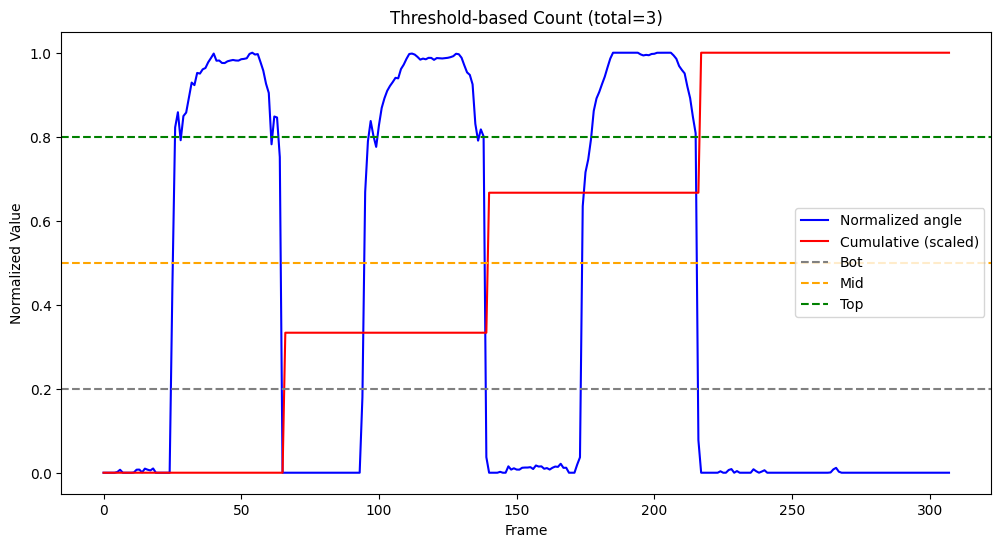

In [33]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# ---------------------- 라이브러리 ----------------------
import json  # JSON 파일 로드를 위해 임포트해요.
from pathlib import Path  # 경로 관리를 위해 임포트해요.
import numpy as np  # 수치 계산을 위해 임포트해요.
import matplotlib.pyplot as plt  # 시각화를 위해 임포트해요.
from math import acos, degrees  # 각도 계산을 위해 임포트해요.

# ---------------------- 경로 ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_JSON"
)  # JSON 키포인트가 저장된 폴더 경로


FPS = 30  # 초당 프레임 수를 지정해요.
BASELINE_FRAMES = 30  # 기준선 계산을 위한 프레임 수를 지정해요.

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:  # JSON 파일을 열어요.
        data = json.load(f)  # JSON을 파싱해요.
    return np.array(data["instance_info"][0]["keypoints"], dtype=float)  # 키포인트 배열을 반환해요.

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2  # 벡터를 계산해요.
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)  # 0 나눔 방지용 작은 값을 더해요.
    cosang = np.dot(v1, v2) / denom  # 코사인을 계산해요.
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))  # 도 단위 각도를 반환해요.

# ---------------------- 키포인트 인덱스 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16,
}  # COCO 체계에 맞는 17개 관절 인덱스예요.

# ---------------------- 8개 관절각 정의 ----------------------
angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- 각도 계산 ----------------------
def compute_all_angles(all_keypoints, angles_def):
    angles = {k: [] for k in angles_def.keys()}  # 각도 결과 저장 딕셔너리를 만들어요.
    for frame in all_keypoints:  # 각 프레임을 순회해요.
        for name, (i, j, k) in angles_def.items():  # 각도 정의를 꺼내요.
            ang = angle_between(frame[i], frame[j], frame[k])  # 각도를 계산해요.
            angles[name].append(ang)  # 리스트에 저장해요.
    return {k: np.asarray(v) for k, v in angles.items()}  # 배열로 반환해요.

# ---------------------- 각도 방향 통일 ----------------------
def unify_direction(angles):
    ext180 = {"L_arm", "R_arm", "L_leg", "R_leg"}  # 180°가 기본인 각도들.
    base0 = {"L_shoulder_hip", "R_shoulder_hip", "L_hip", "R_hip"}  # 0°가 기본인 각도들.
    unified = {}  # 통일 결과를 담을 딕셔너리.
    for name, series in angles.items():  # 각도별로 순회해요.
        if name in ext180:  # 180° 기준이면
            unified[name] = 180 - series  # 굴곡↑ ⇒ 값↑로 변환해요.
        else:  # 0° 기준이면
            unified[name] = series  # 그대로 사용해요.
    return unified

# ---------------------- 기준선 보정 + 0~1 정규화 ----------------------
def normalize_series(series, baseline_frames=30):
    base = np.median(series[:baseline_frames])  # 초기 기준선을 계산해요.
    zeroed = np.maximum(0, series - base)  # 기준선 아래는 0으로 클리핑해요.
    lo, hi = np.percentile(zeroed, [5, 95])  # 분위수를 구해요.
    scale = max(hi - lo, 1e-6)  # 분모가 0이 되지 않게 해요.
    unit = np.clip((zeroed - lo) / scale, 0, 1)  # 0~1로 정규화해요.
    return unit

# ---------------------- Threshold 상태머신 ----------------------
def count_threshold(sig, fps=30, bot=0.2, mid=0.5, top=0.8, min_interval=1.5):
    n = len(sig)  # 프레임 수를 가져와요.
    cum = np.zeros(n)  # 누적 카운트를 저장할 배열이에요.
    cnt = 0  # 카운트 시작값은 0이에요.
    state = "idle"  # 초기 상태는 idle이에요.
    last_count = -1e9  # 마지막 카운트 프레임을 먼 과거로 둬요.
    min_gap = int(min_interval * fps)  # 최소 간격을 프레임으로 환산해요.

    for i, v in enumerate(sig):  # 모든 프레임을 순회해요.
        if state == "idle" and v >= mid:  # Mid 이상 올라가면 rising 상태로 전환해요.
            state = "rising"
        elif state == "rising" and v >= top:  # Top 이상이면 top 상태로 전환해요.
            state = "top"
        elif state == "top" and v <= mid:  # 다시 Mid 아래로 내려오면 falling 상태예요.
            state = "falling"
        elif state == "falling" and v <= bot:  # Bot까지 내려오면 동작 1회로 카운트해요.
            if i - last_count >= min_gap:  # 최소 간격 조건을 만족하면
                cnt += 1  # 카운트를 1 증가해요.
                last_count = i  # 마지막 카운트 시점을 갱신해요.
            state = "idle"  # 상태를 idle로 초기화해요.
        cum[i] = cnt  # 누적 카운트를 기록해요.
    return cum, cnt  # 프레임별 누적 카운트와 총 카운트를 반환해요.

# ---------------------- 실행 ----------------------
if __name__ == "__main__":
    json_files = sorted(KP_DIR.glob("*.json"))  # JSON 파일들을 정렬해요.
    keypoints = np.array([load_keypoints(f) for f in json_files])  # 모든 프레임 키포인트를 로드해요.
    angles_raw = compute_all_angles(keypoints, angles_def)  # 8개 관절각을 계산해요.
    angles_uni = unify_direction(angles_raw)  # 각도를 굴곡↑ ⇒ 값↑ 방향으로 통일해요.

    # 예시: L_arm을 사용 (자동 선택 로직 넣을 수도 있음)
    series = normalize_series(angles_uni["L_arm"], baseline_frames=BASELINE_FRAMES)  # 정규화해요.
    cum, total = count_threshold(series, fps=FPS)  # Threshold 기반 카운트를 해요.

    print(f"✅ 최종 카운트: {total}")  # 최종 카운트를 출력해요.

    # ---------------------- 시각화 ----------------------
    plt.figure(figsize=(12,6))  # 그래프 크기를 지정해요.
    plt.plot(series, label="Normalized angle", color="blue")  # 정규화된 각도를 그려요.
    plt.plot(cum / max(cum.max(), 1), label="Cumulative (scaled)", color="red")  # 누적 카운트를 0~1로 스케일해 같이 그려요.
    plt.axhline(0.2, color="gray", linestyle="--", label="Bot")  # Bot 임계선을 그려요.
    plt.axhline(0.5, color="orange", linestyle="--", label="Mid")  # Mid 임계선을 그려요.
    plt.axhline(0.8, color="green", linestyle="--", label="Top")  # Top 임계선을 그려요.
    plt.legend()  # 범례를 표시해요.
    plt.title(f"Threshold-based Count (total={total})")  # 그래프 제목을 넣어요.
    plt.xlabel("Frame")  # x축 라벨을 넣어요.
    plt.ylabel("Normalized Value")  # y축 라벨을 넣어요.
    plt.show()  # 그래프를 출력해요.


📌 후보 진폭 점수: {'L_arm': 177.83237701571466, 'R_arm': 174.53964245156737, 'L_shoulder_hip': 14.888354763322743, 'R_shoulder_hip': 15.423712294696353, 'L_leg': 4.124132124161889, 'R_leg': 5.320894181118035, 'L_hip': 4.2487235721376635, 'R_hip': 6.6119425050763425}
✅ 선택된 angle: L_arm
✅ Auto Thresholds → Bot=44.10, Mid=115.23, Top=150.80
✅ 최종 카운트: 3


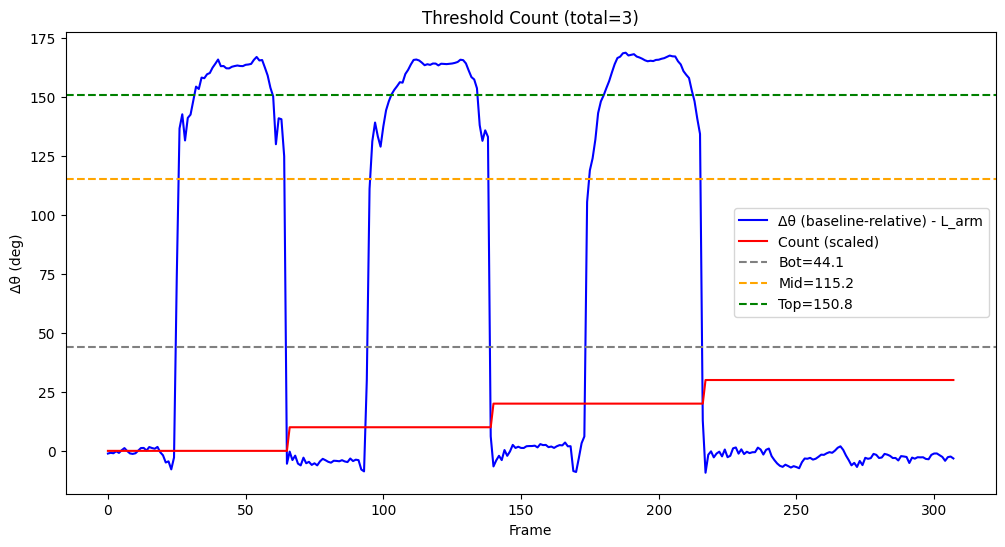

In [45]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from math import acos, degrees

# ---------------------- 경로 ----------------------
KP_DIR = Path(
    "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/"
    "data/2_KEYPOINTS_OLD/sample_data/ward_sample_video/15_앉아서 양손 물통 잡고 옆으로 팔 올리기 2_JSON"
)  # JSON 키포인트가 저장된 폴더 경로



FPS = 30
BASELINE_FRAMES = 30
MIN_INTERVAL_SEC = 1.5  # 연속 카운트 방지 최소 간격

# ---------------------- 유틸 함수 ----------------------
def load_keypoints(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return np.array(data["instance_info"][0]["keypoints"], dtype=float)

def angle_between(p1, p2, p3):
    v1, v2 = p1 - p2, p3 - p2
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    cosang = np.dot(v1, v2) / denom
    return degrees(acos(np.clip(cosang, -1.0, 1.0)))

# ---------------------- 키포인트 인덱스 ----------------------
keypoint_indices = {
    "left_shoulder": 5, "right_shoulder": 6,
    "left_elbow": 7, "right_elbow": 8,
    "left_wrist": 9, "right_wrist": 10,
    "left_hip": 11, "right_hip": 12,
    "left_knee": 13, "right_knee": 14,
    "left_ankle": 15, "right_ankle": 16,
}

# ---------------------- 8개 각도 정의 ----------------------
angles_def = {
    "L_arm": (keypoint_indices["left_shoulder"], keypoint_indices["left_elbow"], keypoint_indices["left_wrist"]),
    "R_arm": (keypoint_indices["right_shoulder"], keypoint_indices["right_elbow"], keypoint_indices["right_wrist"]),
    "L_shoulder_hip": (keypoint_indices["left_elbow"], keypoint_indices["left_shoulder"], keypoint_indices["left_hip"]),
    "R_shoulder_hip": (keypoint_indices["right_elbow"], keypoint_indices["right_shoulder"], keypoint_indices["right_hip"]),
    "L_leg": (keypoint_indices["left_hip"], keypoint_indices["left_knee"], keypoint_indices["left_ankle"]),
    "R_leg": (keypoint_indices["right_hip"], keypoint_indices["right_knee"], keypoint_indices["right_ankle"]),
    "L_hip": (keypoint_indices["left_shoulder"], keypoint_indices["left_hip"], keypoint_indices["left_knee"]),
    "R_hip": (keypoint_indices["right_shoulder"], keypoint_indices["right_hip"], keypoint_indices["right_knee"]),
}

# ---------------------- 관절각 계산 ----------------------
def compute_all_angles(all_keypoints, angles_def):
    angles = {k: [] for k in angles_def.keys()}
    for frame in all_keypoints:
        for name, (i, j, k) in angles_def.items():
            ang = angle_between(frame[i], frame[j], frame[k])
            angles[name].append(ang)
    return {k: np.asarray(v) for k, v in angles.items()}

# ---------------------- 방향 통일 ----------------------
def unify_direction(angles):
    ext180 = {"L_arm", "R_arm", "L_leg", "R_leg"}  # 기본 180°
    unified = {}
    for name, series in angles.items():
        if name in ext180:
            unified[name] = 180 - series  # 펴질수록 0, 굽힐수록 ↑
        else:
            unified[name] = series  # 기본 0° → 그대로
    return unified

# ---------------------- baseline-relative ----------------------
def baseline_relative(series, baseline_frames=30):
    baseline = np.median(series[:min(len(series), baseline_frames)])
    return series - baseline

# ---------------------- range 기반 threshold ----------------------
def auto_thresholds_range(dtheta, bot_ratio=0.3, mid_ratio=0.7, top_ratio=0.9):
    lo, hi = np.min(dtheta), np.max(dtheta)
    amp = hi - lo
    bot = lo + bot_ratio * amp
    mid = lo + mid_ratio * amp
    top = lo + top_ratio * amp
    return bot, mid, top

# ---------------------- 상태머신 ----------------------
def count_threshold(dtheta, fps=30, bot=15, mid=30, top=50, min_interval=1.5):
    n = len(dtheta)
    cum = np.zeros(n)
    cnt = 0
    state = "idle"
    last_count = -1e9
    min_gap = int(min_interval * fps)

    for i, v in enumerate(dtheta):
        if state == "idle" and v >= mid:
            state = "rising"
        elif state == "rising" and v >= top:
            state = "top"
        elif state == "top" and v <= mid:
            state = "falling"
        elif state == "falling" and v <= bot:
            if i - last_count >= min_gap:
                cnt += 1
                last_count = i
            state = "idle"
        cum[i] = cnt
    return cum, cnt

# ---------------------- 실행 ----------------------
if __name__ == "__main__":
    # 1. keypoints 로드
    json_files = sorted(KP_DIR.glob("*.json"))
    keypoints = np.array([load_keypoints(f) for f in json_files])

    # 2. 관절각 계산 + 방향 통일
    angles_raw = compute_all_angles(keypoints, angles_def)
    angles_uni = unify_direction(angles_raw)

    # 3. 가장 크게 움직이는 angle 선택
    scores = {k: np.ptp(baseline_relative(v)) for k, v in angles_uni.items()}
    best_angle = max(scores.items(), key=lambda x: x[1])[0]
    print("📌 후보 진폭 점수:", scores)
    print("✅ 선택된 angle:", best_angle)

    # 4. baseline-relative Δθ
    dtheta = baseline_relative(angles_uni[best_angle], baseline_frames=BASELINE_FRAMES)

    # 5. range 기반 threshold
    bot, mid, top = auto_thresholds_range(dtheta)
    print(f"✅ Auto Thresholds → Bot={bot:.2f}, Mid={mid:.2f}, Top={top:.2f}")

    # 6. 카운팅
    cum, total = count_threshold(dtheta, fps=FPS, bot=bot, mid=mid, top=top,
                                 min_interval=MIN_INTERVAL_SEC)
    print(f"✅ 최종 카운트: {total}")

    # 7. 시각화
    plt.figure(figsize=(12,6))
    plt.plot(dtheta, label=f"Δθ (baseline-relative) - {best_angle}", color="blue")
    plt.plot(cum * 10, label="Count (scaled)", color="red")  # count 보기 쉽게
    plt.axhline(bot, color="gray", linestyle="--", label=f"Bot={bot:.1f}")
    plt.axhline(mid, color="orange", linestyle="--", label=f"Mid={mid:.1f}")
    plt.axhline(top, color="green", linestyle="--", label=f"Top={top:.1f}")
    plt.legend()
    plt.title(f"Threshold Count (total={total})")
    plt.xlabel("Frame")
    plt.ylabel("Δθ (deg)")
    plt.show()
